In [1]:
import tensorflow as tf
import matplotlib.pylab as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-01-04 03:46:23.954399: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-04 03:46:24.007750: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-04 03:46:24.007776: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-04 03:46:24.007782: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-04 03:46:24.014005: I tensorflow/core/platform/cpu_feature_g

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [3]:
def train_val_generators(TRAINING_DIR):

  # Instantiate the ImageDataGenerator class
  validation_split=0.1
  # Don't forget to normalize pixel values and set arguments to augment the images
  train_datagen = ImageDataGenerator(rescale=1./255,
                                     validation_split=validation_split)

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=16,
                                                      class_mode='categorical',
                                                      target_size=(224, 224),
                                                      subset='training')
  
  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=16,
                                                      class_mode='categorical',
                                                      target_size=(224, 224),
                                                      subset='validation')

  return train_generator, validation_generator

In [4]:
train_dir = 'pisang/pisang_artificial_ripen/Train'
test_dir = 'pisang/pisang_artificial_ripen/Test'

In [5]:
# Test generators
train_generator, validation_generator = train_val_generators(train_dir)

Found 7233 images belonging to 12 classes.
Found 800 images belonging to 12 classes.


In [6]:
pretrained_resnet = tf.keras.applications.ResNet152(
    include_top=False,
    input_shape=(224, 224, 3),
    weights='imagenet'
)

2024-01-04 03:46:28.597273: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 25102 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:af:00.0, compute capability: 7.5


## 0,1

In [7]:
x_resnet = pretrained_resnet.output
x_resnet = tf.keras.layers.GlobalAveragePooling2D()(x_resnet)
x_resnet = tf.keras.layers.Dropout(0.1)(x_resnet)
predictions_resnet = tf.keras.layers.Dense(12, activation='softmax')(x_resnet)
model_resnet = tf.keras.Model(inputs=pretrained_resnet.input, outputs=predictions_resnet)

In [8]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
#pretrained_mobile.trainable = False
sgd = tf.keras.optimizers.SGD(learning_rate=0.0001)
model_resnet.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=["accuracy"])

filepath = 'new_test/new-test-resnet-sgd-dropout-0,1-lr-0,0001.h5'

modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = True,
    save_weights_only = False,
    mode = 'max',
    save_freq = 'epoch'
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=20,
    verbose=1,
)
train_log=tf.keras.callbacks.CSVLogger(
    filename='new-test-resnet-sgd-dropout-0,1-lr-0,0001.log', 
    separator=','
)
callbacksList = [modelCheckpoint, early_stopping, train_log]
train_resnet = model_resnet.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=100,
                    callbacks = callbacksList,
                    verbose=1)
model_resnet.save('new_test/new-test-resnet-sgd-dropout-0,1-lr-0,0001-completed.h5')

Epoch 1/100


2024-01-03 20:53:02.357272: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2024-01-03 20:53:03.042845: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-03 20:53:03.257948: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-03 20:53:04.818881: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f5d351ba2e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-03 20:53:04.818912: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
2024-01-03 20:53:04.933136: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


227/227 [==============================] - ETA: 0s - loss: 2.5890 - accuracy: 0.1149
Epoch 1: val_accuracy improved from -inf to 0.08125, saving model to new_test/new-test-resnet-sgd-dropout-0,1-lr-0,0001.h5


/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


227/227 [==============================] - 153s 419ms/step - loss: 2.5890 - accuracy: 0.1149 - val_loss: 4.6012 - val_accuracy: 0.0812
Epoch 2/100
227/227 [==============================] - ETA: 0s - loss: 2.2070 - accuracy: 0.2371
Epoch 2: val_accuracy did not improve from 0.08125
227/227 [==============================] - 91s 399ms/step - loss: 2.2070 - accuracy: 0.2371 - val_loss: 13.8556 - val_accuracy: 0.0812
Epoch 3/100
227/227 [==============================] - ETA: 0s - loss: 1.9781 - accuracy: 0.3391
Epoch 3: val_accuracy did not improve from 0.08125
227/227 [==============================] - 92s 404ms/step - loss: 1.9781 - accuracy: 0.3391 - val_loss: 8.9729 - val_accuracy: 0.0812
Epoch 4/100
227/227 [==============================] - ETA: 0s - loss: 1.7827 - accuracy: 0.4114
Epoch 4: val_accuracy improved from 0.08125 to 0.09125, saving model to new_test/new-test-resnet-sgd-dropout-0,1-lr-0,0001.h5
227/227 [==============================] - 93s 408ms/step - loss: 1.7827 - ac

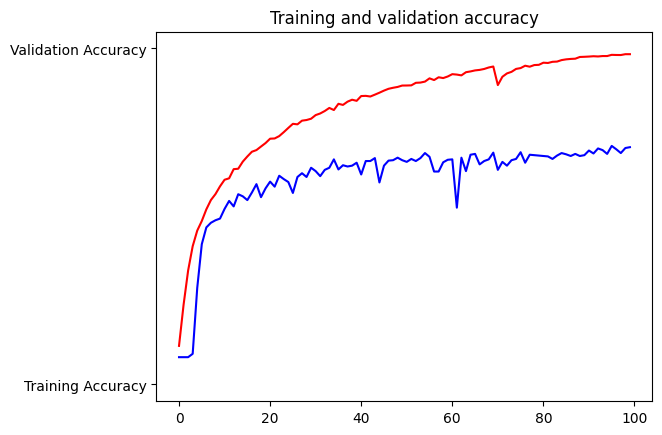

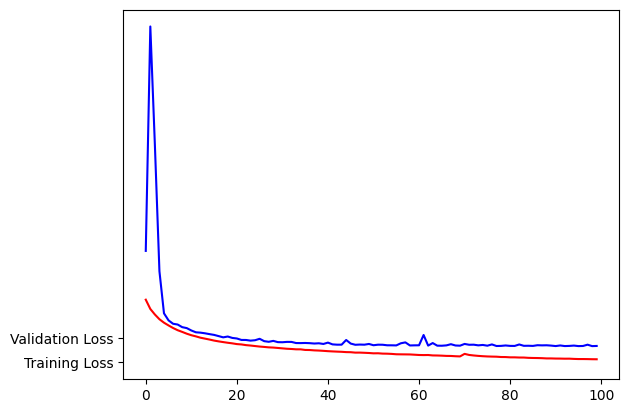

In [9]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc_resnet=train_resnet.history['accuracy']
val_acc_resnet=train_resnet.history['val_accuracy']
loss_resnet=train_resnet.history['loss']
val_loss_resnet=train_resnet.history['val_loss']

epochs_resnet=range(len(acc_resnet)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs_resnet, acc_resnet, 'r', "Training Accuracy")
plt.plot(epochs_resnet, val_acc_resnet, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs_resnet, loss_resnet, 'r', "Training Loss")
plt.plot(epochs_resnet, val_loss_resnet, 'b', "Validation Loss")
plt.show()

## 0,2

In [7]:
x_resnet2 = pretrained_resnet.output
x_resnet2 = tf.keras.layers.GlobalAveragePooling2D()(x_resnet2)
x_resnet2 = tf.keras.layers.Dropout(0.2)(x_resnet2)
predictions_resnet2 = tf.keras.layers.Dense(12, activation='softmax')(x_resnet2)
model_resnet2 = tf.keras.Model(inputs=pretrained_resnet.input, outputs=predictions_resnet2)

In [8]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
#pretrained_mobile.trainable = False
sgd = tf.keras.optimizers.SGD(learning_rate=0.0001)
model_resnet2.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=["accuracy"])

filepath = 'new_test/new-test-resnet-sgd-dropout-0,2-lr-0,0001.h5'

modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = True,
    save_weights_only = False,
    mode = 'max',
    save_freq = 'epoch'
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_accuracy',
    patience = 20,
    mode='max',
    verbose=1
) 
train_log=tf.keras.callbacks.CSVLogger(
    filename='new-test-resnet-sgd-dropout-0,2-lr-0,0001.log', 
    separator=','
)
callbacksList = [modelCheckpoint, train_log, early_stopping]
train_resnet2 = model_resnet2.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=100,
                    callbacks = callbacksList,
                    verbose=1)
model_resnet2.save('new_test/new-test-resnet-sgd-dropout-0,2-lr-0,0001-completed.h5')

Epoch 1/100


2024-01-03 23:04:44.195667: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2024-01-03 23:04:44.803384: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-03 23:04:44.986434: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-03 23:04:46.260246: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa0ded73200 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-03 23:04:46.260278: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
2024-01-03 23:04:46.366223: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


453/453 [==============================] - ETA: 0s - loss: 2.5130 - accuracy: 0.1611
Epoch 1: val_accuracy improved from -inf to 0.11000, saving model to new_test/new-test-resnet-sgd-dropout-0,2-lr-0,0001.h5


/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


453/453 [==============================] - 142s 189ms/step - loss: 2.5130 - accuracy: 0.1611 - val_loss: 5.0688 - val_accuracy: 0.1100
Epoch 2/100
453/453 [==============================] - ETA: 0s - loss: 1.9907 - accuracy: 0.3340
Epoch 2: val_accuracy improved from 0.11000 to 0.12375, saving model to new_test/new-test-resnet-sgd-dropout-0,2-lr-0,0001.h5
453/453 [==============================] - 84s 184ms/step - loss: 1.9907 - accuracy: 0.3340 - val_loss: 2.5536 - val_accuracy: 0.1238
Epoch 3/100
453/453 [==============================] - ETA: 0s - loss: 1.6943 - accuracy: 0.4311
Epoch 3: val_accuracy improved from 0.12375 to 0.35000, saving model to new_test/new-test-resnet-sgd-dropout-0,2-lr-0,0001.h5
453/453 [==============================] - 83s 184ms/step - loss: 1.6943 - accuracy: 0.4311 - val_loss: 2.0207 - val_accuracy: 0.3500
Epoch 4/100
453/453 [==============================] - ETA: 0s - loss: 1.5189 - accuracy: 0.4676
Epoch 4: val_accuracy improved from 0.35000 to 0.40125

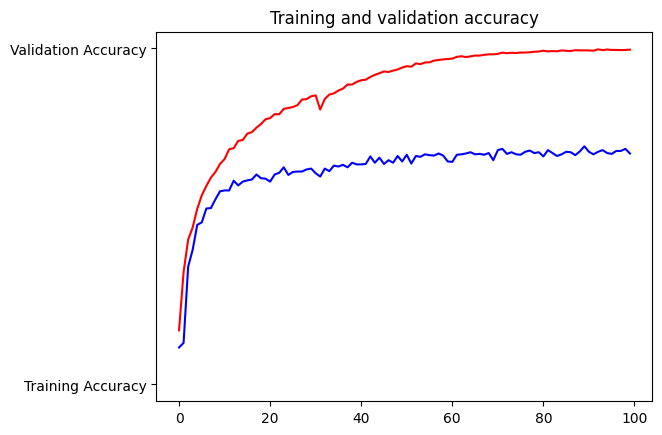

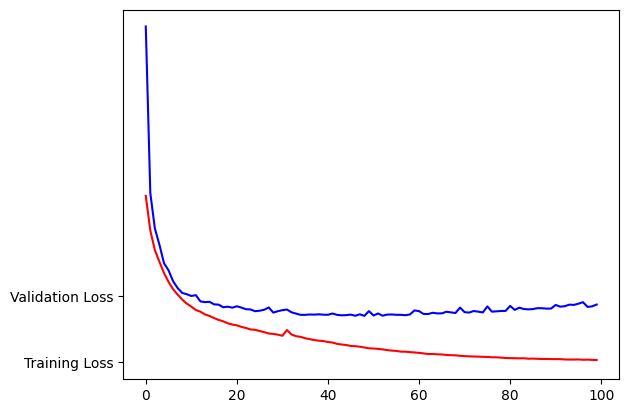

In [10]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc_resnet=train_resnet2.history['accuracy']
val_acc_resnet=train_resnet2.history['val_accuracy']
loss_resnet=train_resnet2.history['loss']
val_loss_resnet=train_resnet2.history['val_loss']

epochs_resnet=range(len(acc_resnet)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs_resnet, acc_resnet, 'r', "Training Accuracy")
plt.plot(epochs_resnet, val_acc_resnet, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs_resnet, loss_resnet, 'r', "Training Loss")
plt.plot(epochs_resnet, val_loss_resnet, 'b', "Validation Loss")
plt.show()

## 0,3

In [8]:
x_resnet = pretrained_resnet.output
x_resnet = tf.keras.layers.GlobalAveragePooling2D()(x_resnet)
x_resnet = tf.keras.layers.Dropout(0.3)(x_resnet)
predictions_resnet = tf.keras.layers.Dense(12, activation='softmax')(x_resnet)
model_resnet = tf.keras.Model(inputs=pretrained_resnet.input, outputs=predictions_resnet)

In [9]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
#pretrained_mobile.trainable = False
sgd = tf.keras.optimizers.SGD(learning_rate=0.0001)
model_resnet.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=["accuracy"])

filepath = 'new_test/new-test-resnet-sgd-dropout-0,3-lr-0,0001.h5'

modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = True,
    save_weights_only = False,
    mode = 'max',
    save_freq = 'epoch'
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_accuracy',
    patience = 20,
    mode='max',
    verbose=1
)
train_log=tf.keras.callbacks.CSVLogger(
    filename='new-test-resnet-sgd-dropout-0,3-lr-0,0001.log', 
    separator=','
)
callbacksList = [modelCheckpoint, train_log, early_stopping]
train_resnet = model_resnet.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=100,
                    callbacks = callbacksList,
                    verbose=1)
model_resnet.save('new_test/new-test-resnet-sgd-dropout-0,3-lr-0,0001-completed.h5')

Epoch 1/100


2024-01-04 01:27:03.404278: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2024-01-04 01:27:04.010198: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-04 01:27:04.195356: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-04 01:27:05.481796: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd0109033f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-04 01:27:05.481829: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
2024-01-04 01:27:05.585271: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


453/453 [==============================] - ETA: 0s - loss: 2.4899 - accuracy: 0.1648
Epoch 1: val_accuracy improved from -inf to 0.08125, saving model to new_test/new-test-resnet-sgd-dropout-0,3-lr-0,0001.h5


/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


453/453 [==============================] - 142s 188ms/step - loss: 2.4899 - accuracy: 0.1648 - val_loss: 50.9893 - val_accuracy: 0.0812
Epoch 2/100
453/453 [==============================] - ETA: 0s - loss: 1.9636 - accuracy: 0.3178
Epoch 2: val_accuracy improved from 0.08125 to 0.10000, saving model to new_test/new-test-resnet-sgd-dropout-0,3-lr-0,0001.h5
453/453 [==============================] - 83s 182ms/step - loss: 1.9636 - accuracy: 0.3178 - val_loss: 9.2815 - val_accuracy: 0.1000
Epoch 3/100
453/453 [==============================] - ETA: 0s - loss: 1.6726 - accuracy: 0.4202
Epoch 3: val_accuracy improved from 0.10000 to 0.42875, saving model to new_test/new-test-resnet-sgd-dropout-0,3-lr-0,0001.h5
453/453 [==============================] - 83s 184ms/step - loss: 1.6726 - accuracy: 0.4202 - val_loss: 1.6326 - val_accuracy: 0.4288
Epoch 4/100
453/453 [==============================] - ETA: 0s - loss: 1.4653 - accuracy: 0.4878
Epoch 4: val_accuracy improved from 0.42875 to 0.4375

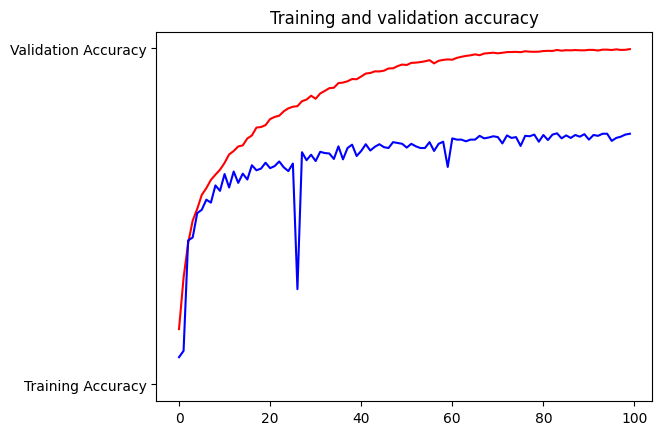

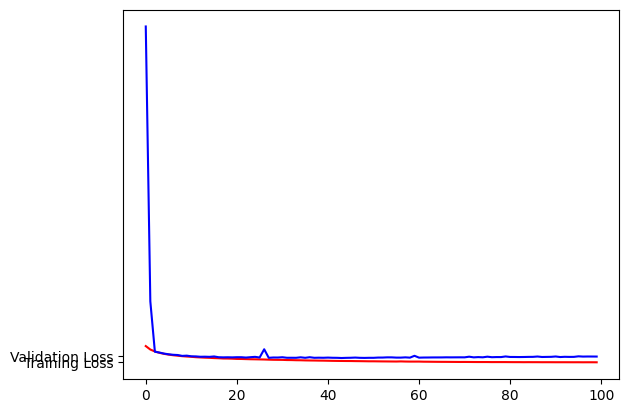

In [10]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc_resnet=train_resnet.history['accuracy']
val_acc_resnet=train_resnet.history['val_accuracy']
loss_resnet=train_resnet.history['loss']
val_loss_resnet=train_resnet.history['val_loss']

epochs_resnet=range(len(acc_resnet)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs_resnet, acc_resnet, 'r', "Training Accuracy")
plt.plot(epochs_resnet, val_acc_resnet, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs_resnet, loss_resnet, 'r', "Training Loss")
plt.plot(epochs_resnet, val_loss_resnet, 'b', "Validation Loss")
plt.show()

## 0,4

In [7]:
x_resnet = pretrained_resnet.output
x_resnet = tf.keras.layers.GlobalAveragePooling2D()(x_resnet)
x_resnet = tf.keras.layers.Dropout(0.4)(x_resnet)
predictions_resnet = tf.keras.layers.Dense(12, activation='softmax')(x_resnet)
model_resnet = tf.keras.Model(inputs=pretrained_resnet.input, outputs=predictions_resnet)

In [8]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
#pretrained_mobile.trainable = False
sgd = tf.keras.optimizers.SGD(learning_rate=0.0001)
model_resnet.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=["accuracy"])

filepath = 'new_test/new-test-resnet-sgd-dropout-0,4-lr-0,0001.h5'

modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = True,
    save_weights_only = False,
    mode = 'max',
    save_freq = 'epoch'
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_accuracy',
    patience = 20,
    mode='max',
    verbose=1
)
train_log=tf.keras.callbacks.CSVLogger(
    filename='new-test-resnet-sgd-dropout-0,4-lr-0,0001.log', 
    separator=','
)
callbacksList = [modelCheckpoint, train_log, early_stopping]
train_resnet = model_resnet.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=100,
                    callbacks = callbacksList,
                    verbose=1)
model_resnet.save('new_test/new-test-resnet-sgd-dropout-0,4-lr-0,0001-completed.h5')

Epoch 1/100


2024-01-04 03:47:04.737013: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2024-01-04 03:47:05.356027: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-04 03:47:05.538351: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-04 03:47:06.809951: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f3669874130 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-04 03:47:06.809983: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
2024-01-04 03:47:06.919153: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


453/453 [==============================] - ETA: 0s - loss: 2.5830 - accuracy: 0.1604
Epoch 1: val_accuracy improved from -inf to 0.09875, saving model to new_test/new-test-resnet-sgd-dropout-0,4-lr-0,0001.h5


/home/dajuma/anaconda3/envs/myenv311/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


453/453 [==============================] - 142s 189ms/step - loss: 2.5830 - accuracy: 0.1604 - val_loss: 6.4577 - val_accuracy: 0.0988
Epoch 2/100
453/453 [==============================] - ETA: 0s - loss: 2.0296 - accuracy: 0.2979
Epoch 2: val_accuracy improved from 0.09875 to 0.17625, saving model to new_test/new-test-resnet-sgd-dropout-0,4-lr-0,0001.h5
453/453 [==============================] - 83s 184ms/step - loss: 2.0296 - accuracy: 0.2979 - val_loss: 2.4878 - val_accuracy: 0.1762
Epoch 3/100
453/453 [==============================] - ETA: 0s - loss: 1.7419 - accuracy: 0.3875
Epoch 3: val_accuracy improved from 0.17625 to 0.40750, saving model to new_test/new-test-resnet-sgd-dropout-0,4-lr-0,0001.h5
453/453 [==============================] - 84s 186ms/step - loss: 1.7419 - accuracy: 0.3875 - val_loss: 1.7074 - val_accuracy: 0.4075
Epoch 4/100
453/453 [==============================] - ETA: 0s - loss: 1.5335 - accuracy: 0.4427
Epoch 4: val_accuracy improved from 0.40750 to 0.44750

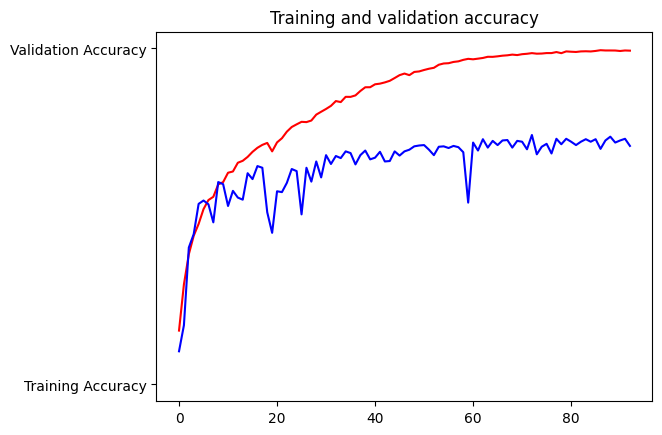

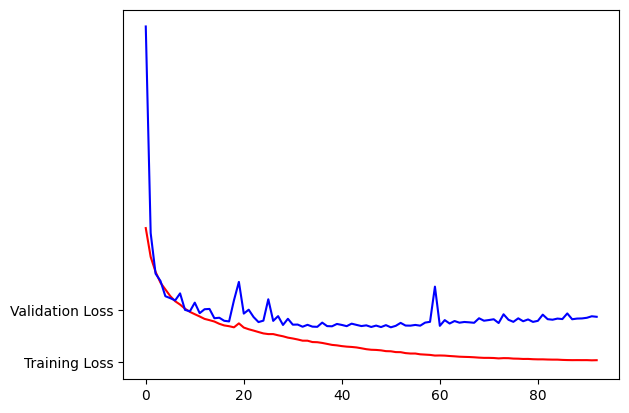

In [9]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc_resnet=train_resnet.history['accuracy']
val_acc_resnet=train_resnet.history['val_accuracy']
loss_resnet=train_resnet.history['loss']
val_loss_resnet=train_resnet.history['val_loss']

epochs_resnet=range(len(acc_resnet)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs_resnet, acc_resnet, 'r', "Training Accuracy")
plt.plot(epochs_resnet, val_acc_resnet, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs_resnet, loss_resnet, 'r', "Training Loss")
plt.plot(epochs_resnet, val_loss_resnet, 'b', "Validation Loss")
plt.show()

# Pengujian

In [6]:
def test_generators(TEST_DIR):
  test_datagen = ImageDataGenerator(rescale=1/255)

  # Pass in the appropriate arguments to the flow_from_directory method
  test_generator = test_datagen.flow_from_directory(directory=TEST_DIR,
                                                                batch_size=256,
                                                                class_mode='categorical',
                                                                target_size=(224, 224))

  return test_generator

In [7]:
test_dir = 'pisang/pisang_artificial_ripen/Test'
# Test generators
test_generator = test_generators(test_dir)
class_labels = list(test_generator.class_indices.keys())

Found 3633 images belonging to 12 classes.


## 0,1

In [8]:
model_resnet = 'new_test/new-test-resnet-sgd-dropout-0,1-completed.h5'

In [9]:
from tensorflow import keras
modelRes = keras.models.load_model(model_resnet)

2023-12-22 21:12:52.685838: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 27142 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:af:00.0, compute capability: 7.5


In [10]:
x, y = test_generator.next()
print("x: ",len(x)," y: ",len(y))

x:  256  y:  256


In [11]:
predResnet = modelRes.predict(x)

2023-12-22 21:13:12.581447: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2023-12-22 21:13:14.368057: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


8/8 [==============================] - 10s 155ms/step


In [12]:
y_pred = []
for i in y:
    y_pred.append(np.argmax(i))

y_test = []
for i in predResnet:
    y_test.append(np.argmax(i))

In [13]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
resnet_accuracy = accuracy_score(y_pred, y_test)
print("ResNet Accuracy:", resnet_accuracy)

ResNet Accuracy: 0.8125


Text(153.75, 0.5, 'Actual Values(y_pred) ')

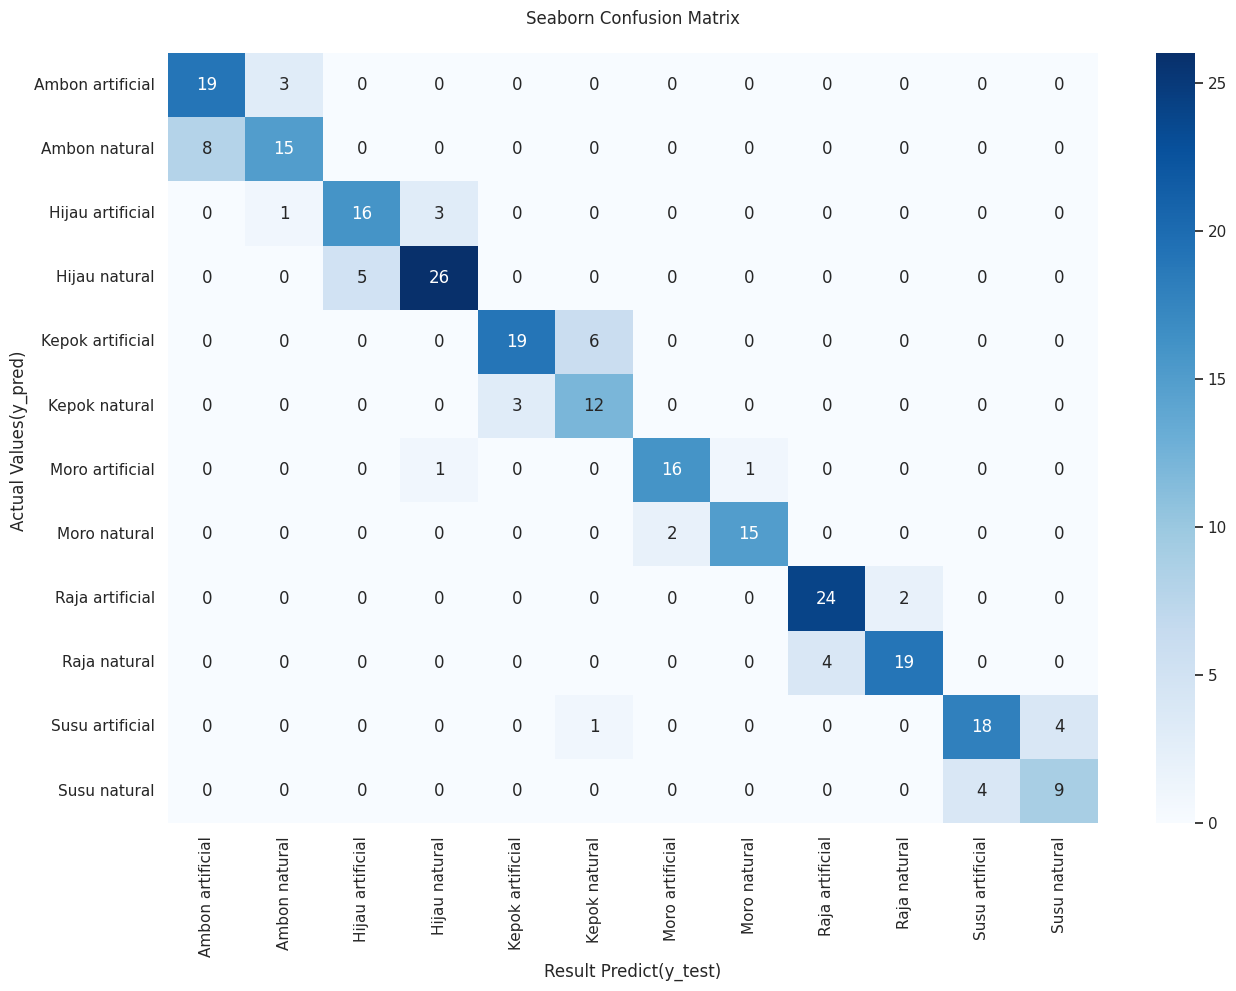

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix_mobile = confusion_matrix(y_test, y_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax_mobile = sns.heatmap(cf_matrix_mobile, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax_mobile.set_title('Seaborn Confusion Matrix\n')
ax_mobile.set_xlabel('Result Predict(y_test)')
ax_mobile.set_ylabel('Actual Values(y_pred) ')

## 0,2

In [8]:
model_resnet = 'new_test/new-test-resnet-sgd-dropout-0,2-completed.h5'

In [9]:
from tensorflow import keras
modelRes = keras.models.load_model(model_resnet)

In [10]:
x, y = test_generator.next()
print("x: ",len(x)," y: ",len(y))

x:  256  y:  256


In [11]:
predResnet = modelRes.predict(x)

2023-12-22 21:14:27.315607: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2023-12-22 21:14:29.033858: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


8/8 [==============================] - 10s 155ms/step


In [12]:
y_pred = []
for i in y:
    y_pred.append(np.argmax(i))

y_test = []
for i in predResnet:
    y_test.append(np.argmax(i))

In [13]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
resnet_accuracy = accuracy_score(y_pred, y_test)
print("ResNet Accuracy:", resnet_accuracy)

ResNet Accuracy: 0.75


Text(153.75, 0.5, 'Actual Values(y_pred) ')

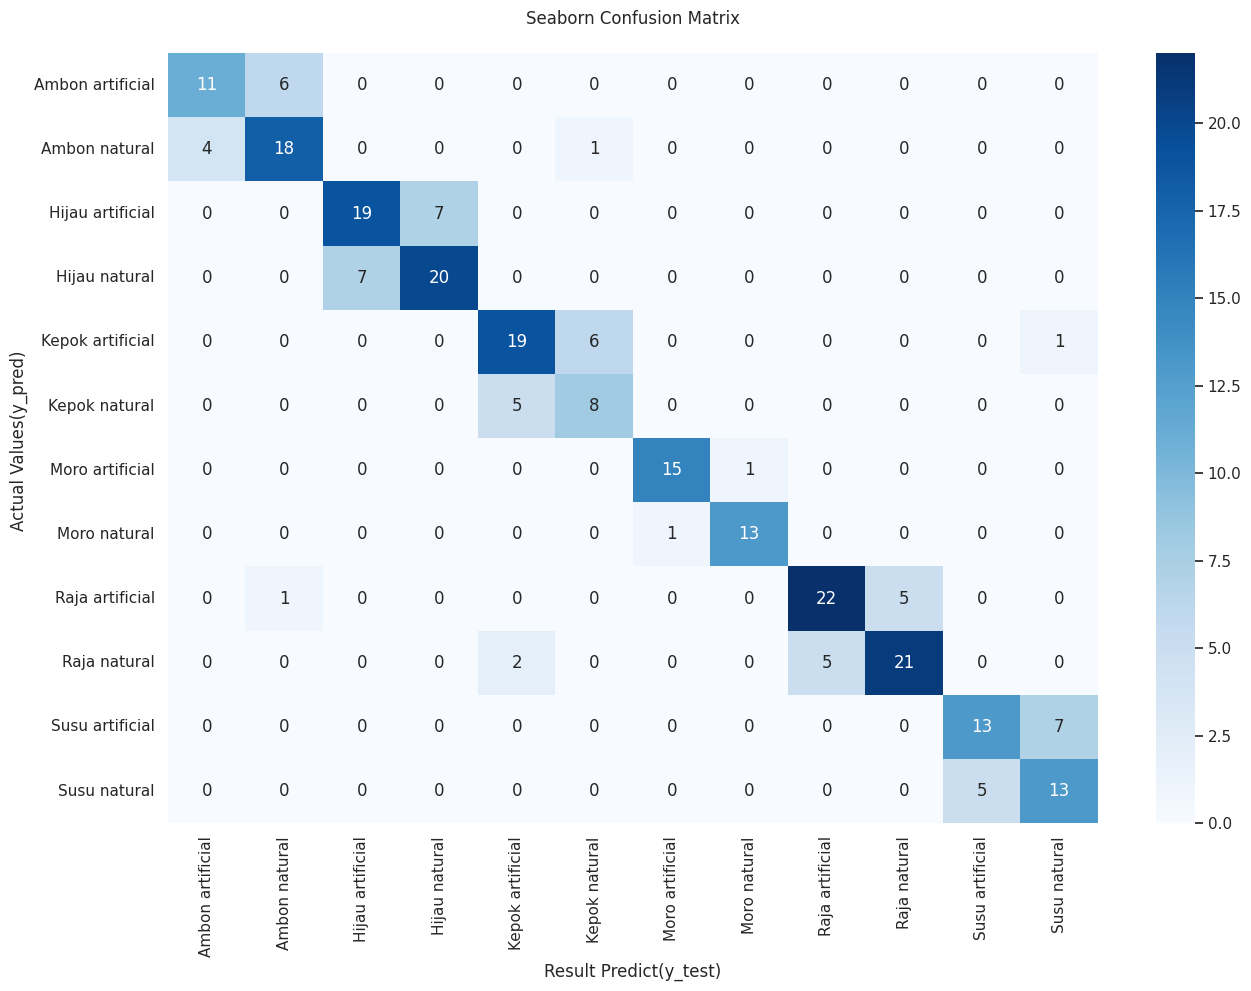

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix_mobile = confusion_matrix(y_test, y_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax_mobile = sns.heatmap(cf_matrix_mobile, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax_mobile.set_title('Seaborn Confusion Matrix\n')
ax_mobile.set_xlabel('Result Predict(y_test)')
ax_mobile.set_ylabel('Actual Values(y_pred) ')

## 0,3

In [15]:
model_resnet = 'new_test/new-test-resnet-sgd-dropout-0,3-completed.h5'

In [16]:
from tensorflow import keras
modelRes = keras.models.load_model(model_resnet)

In [17]:
x, y = test_generator.next()
print("x: ",len(x)," y: ",len(y))

x:  256  y:  256


In [18]:
predResnet = modelRes.predict(x)

8/8 [==============================] - 3s 175ms/step


In [19]:
y_pred = []
for i in y:
    y_pred.append(np.argmax(i))

y_test = []
for i in predResnet:
    y_test.append(np.argmax(i))

In [20]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
resnet_accuracy = accuracy_score(y_pred, y_test)
print("ResNet Accuracy:", resnet_accuracy)

ResNet Accuracy: 0.87890625


Text(153.75, 0.5, 'Actual Values(y_pred) ')

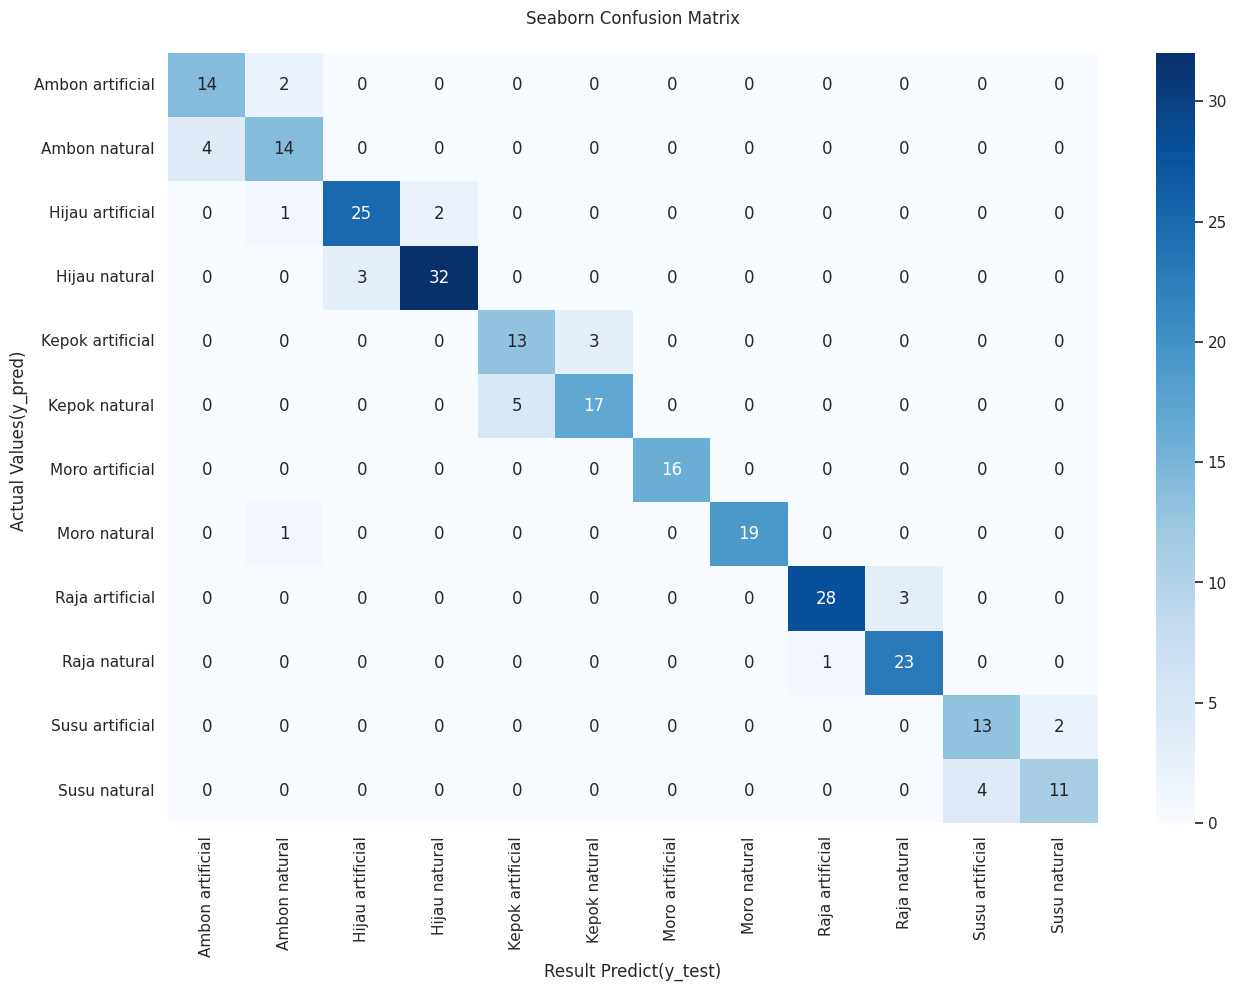

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix_mobile = confusion_matrix(y_test, y_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax_mobile = sns.heatmap(cf_matrix_mobile, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax_mobile.set_title('Seaborn Confusion Matrix\n')
ax_mobile.set_xlabel('Result Predict(y_test)')
ax_mobile.set_ylabel('Actual Values(y_pred) ')

## 0,4

In [22]:
model_resnet = 'new_test/new-test-resnet-sgd-dropout-0,4-completed.h5'

In [23]:
from tensorflow import keras
modelRes = keras.models.load_model(model_resnet)

In [24]:
x, y = test_generator.next()
print("x: ",len(x)," y: ",len(y))

x:  256  y:  256


In [25]:
predResnet = modelRes.predict(x)

8/8 [==============================] - 4s 175ms/step


In [26]:
y_pred = []
for i in y:
    y_pred.append(np.argmax(i))

y_test = []
for i in predResnet:
    y_test.append(np.argmax(i))

In [27]:
from sklearn.metrics import accuracy_score
# Calculate accuracy for the ensemble
resnet_accuracy = accuracy_score(y_pred, y_test)
print("ResNet Accuracy:", resnet_accuracy)

ResNet Accuracy: 0.73046875


Text(153.75, 0.5, 'Actual Values(y_pred) ')

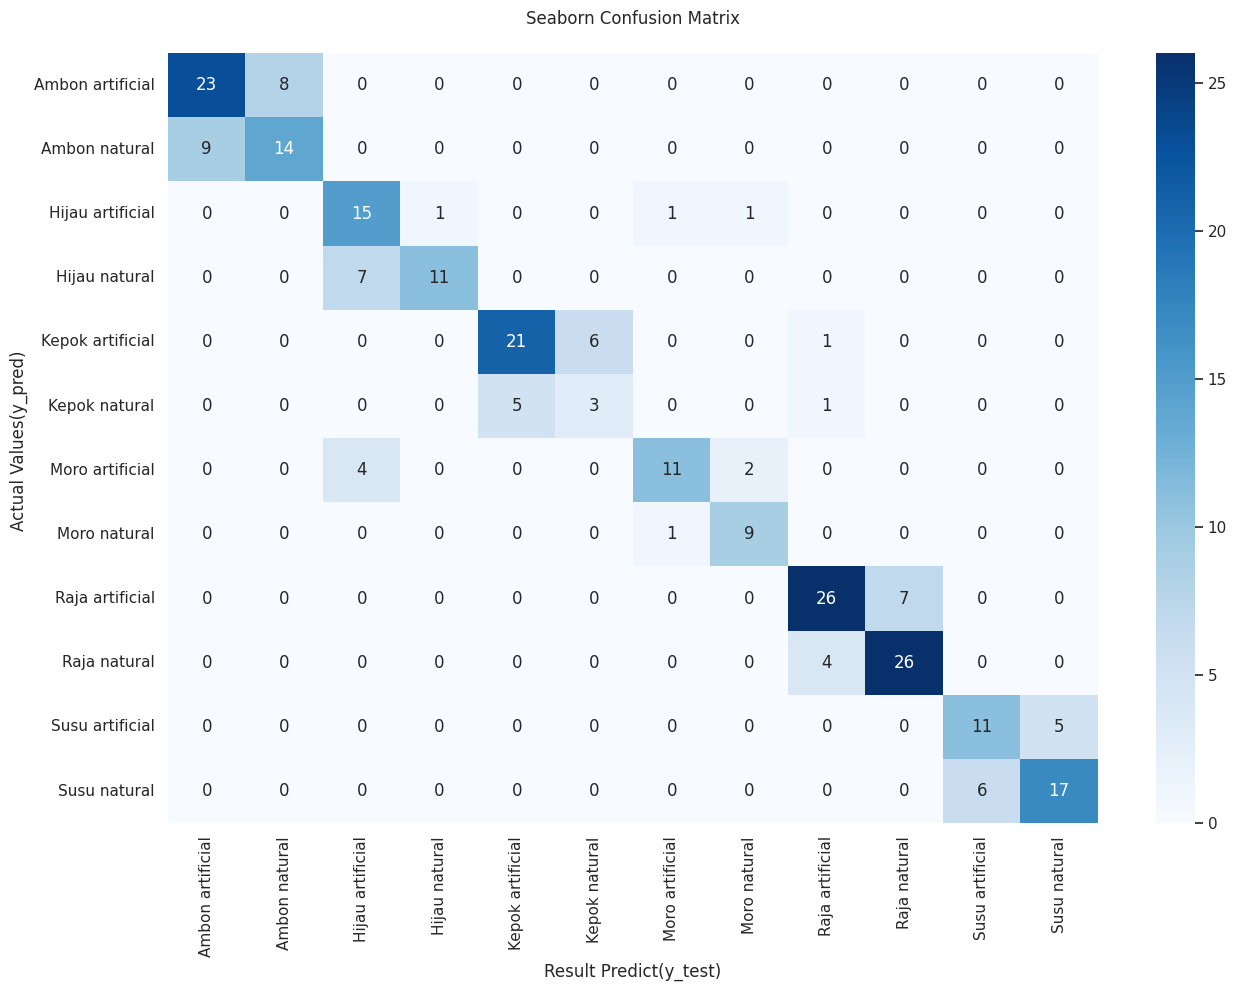

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix_mobile = confusion_matrix(y_test, y_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax_mobile = sns.heatmap(cf_matrix_mobile, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)

ax_mobile.set_title('Seaborn Confusion Matrix\n')
ax_mobile.set_xlabel('Result Predict(y_test)')
ax_mobile.set_ylabel('Actual Values(y_pred) ')